In [2]:
import os
import copy
from tqdm import tqdm
import networkx as nx
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from tqdm import tqdm
import community as community_louvain
# from networkx.algorithms.community import greedy_communities

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

/users/Min/miniconda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/Min/miniconda/lib/python3.11/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /users/Min/miniconda/lib/python3.11/site-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl
  warnings.warn(


1.13.1+cu117


In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print()
print('='*80)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
data.x, torch.min(data.x), torch.max(data.x)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(0.),
 tensor(1.))

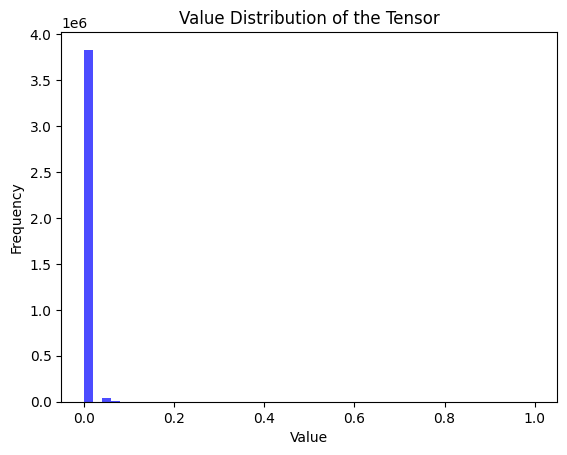

In [5]:
feats = data.x.numpy()
feats = feats.flatten()

# 创建直方图
plt.hist(feats, bins=50, color='blue', alpha=0.7)
plt.title('Value Distribution of the Tensor')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [6]:
from torch_geometric.data import Data

def community_detection(data, model_name, resolution=1):
    # Step 1: Convert Cora dataset to a NetworkX graph
    G = nx.Graph()
    for i in range(data.edge_index.shape[1]):
        source = data.edge_index[0, i].item()
        target = data.edge_index[1, i].item()
        G.add_edge(source, target)

    # Step 2: Apply Louvain community detection
    if model_name == 'louvain':
        partition = community_louvain.best_partition(G)
    elif model_name == 'greedy_modularity':
        communities = greedy_communities(G)
        partition = {}
        for idx, community in enumerate(communities):
            for node in community:
                partition[node] = idx

    # Step 3: Create a new graph based on community assignments
    unique_partitions = np.unique(list(partition.values()))
    community_masks = torch.zeros((data.num_nodes, len(unique_partitions)), dtype=torch.float32)
    subgraphs = []

    for idx, community_id in enumerate(unique_partitions):
        nodes_in_community = [node for node, community in partition.items() if community == community_id]
        community_masks[nodes_in_community, idx] = 1

        # Extract subgraph for each community
        community_subgraph = G.subgraph(nodes_in_community)
        community_edges = torch.tensor(list(community_subgraph.edges)).t().contiguous()
        community_edge_index = torch.cat([community_edges, community_edges.flip(0)], dim=-1)
        community_data = Data(
            x=data.x[nodes_in_community],
            edge_index=community_edge_index,
            y=data.y[nodes_in_community],
            train_mask=data.train_mask[nodes_in_community],
            val_mask=data.val_mask[nodes_in_community],
            test_mask=data.test_mask[nodes_in_community]
        )
        subgraphs.append(community_data)

    return partition, community_masks, subgraphs

In [7]:
import torch_geometric.transforms as T

# Load the Cora dataset
cora_dataset = Planetoid(root='cora', name='Cora', transform=T.NormalizeFeatures())
data = cora_dataset[0]

# Apply community detection
partition, community_masks, subgraphs = community_detection(data, model_name='louvain', resolution=1)


In [8]:
partition

{0: 0,
 633: 0,
 1862: 0,
 2582: 0,
 1: 16,
 2: 16,
 652: 16,
 654: 16,
 332: 2,
 1454: 16,
 1666: 1,
 1986: 0,
 3: 4,
 2544: 4,
 4: 9,
 1016: 9,
 1256: 9,
 1761: 9,
 2175: 9,
 2176: 9,
 5: 35,
 1629: 35,
 1659: 35,
 2546: 35,
 6: 7,
 373: 7,
 1042: 7,
 1416: 7,
 1602: 7,
 7: 8,
 208: 8,
 8: 9,
 269: 9,
 281: 9,
 1996: 9,
 9: 35,
 723: 35,
 2614: 35,
 10: 10,
 476: 10,
 2545: 10,
 11: 11,
 1655: 11,
 1839: 11,
 12: 12,
 1001: 12,
 1318: 12,
 2661: 12,
 2662: 12,
 13: 13,
 1701: 0,
 1810: 13,
 14: 13,
 158: 13,
 2034: 13,
 2075: 13,
 2077: 13,
 2668: 13,
 15: 15,
 1090: 15,
 1093: 15,
 1271: 15,
 2367: 15,
 16: 35,
 970: 35,
 1632: 35,
 2444: 35,
 2642: 35,
 17: 0,
 24: 0,
 927: 0,
 1315: 0,
 1316: 0,
 2140: 0,
 18: 10,
 139: 10,
 1560: 10,
 1786: 10,
 2082: 10,
 2145: 16,
 19: 17,
 1939: 17,
 20: 26,
 1072: 10,
 2269: 26,
 2270: 26,
 2374: 26,
 2375: 26,
 21: 19,
 1043: 19,
 2310: 19,
 22: 20,
 39: 28,
 1234: 20,
 1702: 20,
 1703: 20,
 2238: 20,
 23: 22,
 2159: 22,
 201: 0,
 598: 0,
 1

In [9]:
community_masks, community_masks.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([2708, 105]))

In [10]:
subgraphs[0]

Data(x=[173, 1433], edge_index=[2, 554], y=[173], train_mask=[173], val_mask=[173], test_mask=[173])

In [11]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, alpha):
        super().__init__()
        torch.manual_seed(42)
        self.alpha = alpha
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.conv2(x, edge_index)
        return x, out

In [12]:
model = GCN(data.num_features, 512, dataset.num_classes, alpha=0.5)
model

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)

In [13]:
x, out = model(data.x, data.edge_index)
x, x.shape

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0036],
         [0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0212, 0.0000,  ..., 0.0071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0237, 0.0000, 0.0000],
         [0.0000, 0.0070, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        grad_fn=<MulBackward0>),
 torch.Size([2708, 512]))

In [14]:
out, out.shape

(tensor([[ 0.0070, -0.0019,  0.0010,  ..., -0.0016, -0.0019,  0.0007],
         [-0.0008, -0.0002,  0.0025,  ..., -0.0048, -0.0040,  0.0066],
         [ 0.0084, -0.0072, -0.0010,  ...,  0.0033, -0.0011, -0.0005],
         ...,
         [-0.0040,  0.0138, -0.0039,  ..., -0.0004, -0.0018, -0.0028],
         [ 0.0102, -0.0034, -0.0043,  ...,  0.0041, -0.0012, -0.0017],
         [ 0.0065, -0.0052, -0.0023,  ...,  0.0018, -0.0004, -0.0034]],
        grad_fn=<AddBackward0>),
 torch.Size([2708, 7]))

In [15]:
community_masks, community_masks[:,0], community_masks[:,1]

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1., 0., 0.,  ..., 0., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [16]:
x, x[0,:]

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0036],
         [0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0212, 0.0000,  ..., 0.0071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0237, 0.0000, 0.0000],
         [0.0000, 0.0070, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        grad_fn=<MulBackward0>),
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0476e-03, 0.0000e+00, 3.3942e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7982e-03, 1.2336e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [17]:
rows = []
cols = torch.arange(community_masks.size(1))
for col in cols:
    row = (community_masks[:, col] == 1).nonzero().view(-1)
    rows.append(row)

rows

[tensor([   0,   17,   24,   54,   68,   71,   79,  143,  157,  160,  165,  169,
          176,  179,  197,  201,  206,  215,  226,  231,  232,  235,  261,  267,
          277,  304,  311,  314,  316,  335,  343,  366,  387,  391,  416,  445,
          460,  467,  493,  521,  522,  532,  547,  553,  566,  569,  570,  571,
          598,  603,  633,  664,  670,  673,  674,  690,  696,  716,  717,  743,
          745,  766,  767,  784,  845,  869,  873,  874,  909,  920,  926,  927,
          960,  968,  975, 1023, 1052, 1057, 1066, 1100, 1110, 1120, 1126, 1127,
         1132, 1166, 1172, 1212, 1244, 1247, 1295, 1297, 1299, 1301, 1315, 1316,
         1323, 1357, 1434, 1440, 1453, 1473, 1479, 1570, 1574, 1583, 1603, 1615,
         1636, 1665, 1679, 1701, 1708, 1759, 1820, 1821, 1823, 1852, 1853, 1854,
         1857, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1868, 1870, 1872,
         1873, 1875, 1876, 1893, 1907, 1986, 1987, 1989, 1990, 1994, 1995, 2000,
         2004, 2005, 2007, 2

In [18]:
x[rows[-1][0],:], x[rows[-1][1],:], x[rows[-1][0],:].shape, x[rows[-1][1],:].shape

(tensor([0.0000e+00, 9.0281e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5319e-03, 0.0000e+00, 0.0000e+00,
         2.0794e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 8.1527e-03, 8.4427e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0469e-02, 0.0000e+00, 0.0000e+00,
         2.0644e-02, 1.2677e-02, 0.0000e+00, 2.7159e-02, 0.0000e+00, 1.2695e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.0760e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.1283e-02, 6.7606e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         7.2078e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.6180e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [19]:
input1,input2 = x[rows[-2][0],:].unsqueeze(dim=1), x[rows[-1][1],:].unsqueeze(dim=1)

simi_tensor = F.cosine_similarity(input1,input2, dim=1, eps=1e-8)
dist_tensor = 1 - simi_tensor

simi_tensor, dist_tensor, simi_tensor.shape

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.,

In [20]:
torch.mean(simi_tensor), torch.mean(dist_tensor)

(tensor(0.0547, grad_fn=<MeanBackward0>),
 tensor(0.9453, grad_fn=<MeanBackward0>))

In [21]:
data.y[rows[-2][0]], data.y[rows[-1][1]]

(tensor(3), tensor(3))

In [22]:
model

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
cross_entropy = torch.nn.CrossEntropyLoss()

In [24]:
node_idx = torch.arange(data.x.size(0)).unsqueeze(dim=0)
node_idx, node_idx.shape

(tensor([[   0,    1,    2,  ..., 2705, 2706, 2707]]), torch.Size([1, 2708]))

In [25]:
community_masks.shape

torch.Size([2708, 105])

In [26]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.savefig('figs/cora_madgap.png')


def accuracy(y_pred, y_true):
    
    correct = y_pred.eq(y_true).double()
    correct = correct.sum().item()
    return correct / len(y_true)

### 关键思路：
1. 找到节点所属社团（在community_mask里通过行号关联找到非零列号）；
2. 计算节点表示和（根据非零列号索引集合对应的）相同社团节点表示两者的相似性和距离，同时可以计算不同社团之间的相似性和距离，我们希望相同社团的相似性高，不同社团对应的相似性低；
3. 基于此构造loss函数中的归一化项，然后结合交叉熵用于节点分类，实现模型的训练和学习；


In [27]:
# 先构建社团图
def construct_community_graph(edges, community_assignments):
    # 1. 为每个社团分配一个唯一的编号
    unique_communities = list(set(community_assignments))
    community_id_map = {community: idx for idx, community in enumerate(unique_communities)}

    # 2. 创建新的社团图
    community_graph = nx.Graph()

    # 3. 计算社团之间的距离（这里采用社团之间是否存在连接作为距离度量）
    for edge in edges:
        community1 = community_assignments[edge[0]]
        community2 = community_assignments[edge[1]]

        # 判断社团1和社团2是否有连接，如果有，则在社团图中添加一条边
        if community1 != community2:
            if not community_graph.has_edge(community_id_map[community1], community_id_map[community2]):
                community_graph.add_edge(community_id_map[community1], community_id_map[community2])

    # 计算社团图中任意两个社团之间的距离值
    # 这里采用社团图的最短路径距离
    community_distances = dict(nx.all_pairs_shortest_path_length(community_graph))

    return community_graph, community_distances

# 示例数据
edges = [(1, 2), (1, 3), (2, 4), (2, 3), (4, 5), (4, 6)]
community_assignments = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}

# 构建社团图和计算社团之间的距离
community_graph, community_distances = construct_community_graph(edges, community_assignments)

# 输出社团图和社团之间的距离
print("社团图的节点：", community_graph.nodes)
print("社团之间的距离：", community_distances)

KeyError: 0

In [30]:
# 只考虑不同社团的情况
def get_neg_node(data, node, row):
    neg_node = []
    if len(neg_node) == row.size(0):
        neg_node = torch.stack(neg_node)
        return neg_node
            
    else:
        for target_node in torch.arange(data.x.size(0)):
            if target_node != node:
                if torch.eq(row, target_node).any():
                    continue
                else:
                    neg_node.append(target_node)
            if len(neg_node) == row.size(0):
                break
        
        neg_node = torch.stack(neg_node)
        # print('*'*100)
        # print(neg_node, neg_node.shape)
        return neg_node

# def get_neg_node(data, node, row):
#     # 创建一个布尔掩码，标记哪些节点是正样本
#     is_positive = torch.zeros(data.num_nodes, dtype=torch.bool)
#     is_positive[row] = True

#     # 通过异或操作找到负样本节点
#     is_negative = ~is_positive

#     # 去除自身节点
#     is_negative[node] = False

#     # 获取负样本节点的索引
#     neg_node = torch.nonzero(is_negative, as_tuple=False).squeeze()
#     print('*'*100)
#     print(neg_node, neg_node.shape)
#     return neg_node


In [31]:
subgraphs[0], subgraphs[1]

(Data(x=[173, 1433], edge_index=[2, 554], y=[173], train_mask=[173], val_mask=[173], test_mask=[173]),
 Data(x=[30, 1433], edge_index=[2, 88], y=[30], train_mask=[30], val_mask=[30], test_mask=[30]))

In [32]:
# for node in torch.arange(data.x.size(0))[data.train_mask]:
#     print(node)

In [34]:
best_val_acc = 0
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    emb, out = model(data.x, data.edge_index)
    loss1 = cross_entropy(out[data.train_mask], data.y[data.train_mask])
    same_com_cos_sim, diff_com_cos_sim = [], []
    for node in torch.arange(data.x.size(0))[data.train_mask]:
        # for the same community
        col = (community_masks[node, :] == 1).nonzero().view(-1)
        
        row = (community_masks[:, col] == 1).nonzero()[:,0].view(-1)
        # if node == torch.tensor(1):
        #     print('anchor and positive nodes:')
        # print('='*100)
        # print(row, row.shape)
        cos_sim = F.cosine_similarity(emb[node,:].unsqueeze(dim=1), emb[row,:].unsqueeze(dim=1))
        cos_sim = torch.norm(cos_sim, p=2, dim=0, keepdim=False)
        # print(cos_sim.shape)
        same_com_cos_sim.append(cos_sim.unsqueeze(dim=0))

        # for different communities
        neg_node = get_neg_node(data, node, row)
        # print('negative nodes:')
        # print(neg_node, neg_node.shape)
        neg_cos_sim = F.cosine_similarity(emb[node,:].unsqueeze(dim=1), emb[neg_node,:].unsqueeze(dim=1))
        neg_cos_sim = torch.norm(neg_cos_sim, p=2, dim=0, keepdim=False)
        diff_com_cos_sim.append(neg_cos_sim.unsqueeze(dim=0))

    same_com_cos_sim = torch.stack(same_com_cos_sim)
    same_com_cos_sim = same_com_cos_sim.squeeze(dim=1)
    # print(same_com_cos_sim, same_com_cos_sim.shape)
    same_com_dis = 1 - same_com_cos_sim
    same_com_dis = torch.norm(same_com_dis, p=2, dim=0) # p=2表示l2归一化，dim=1表示按行

    diff_com_cos_sim = torch.stack(diff_com_cos_sim)
    diff_com_cos_sim = diff_com_cos_sim.squeeze(dim=1)
    # print(diff_com_cos_sim, diff_com_cos_sim.shape)
    diff_com_dis = 1 - diff_com_cos_sim
    diff_com_dis = torch.norm(diff_com_dis, p=2, dim=0)

    loss2 = diff_com_dis - same_com_dis

    # print('=======loss:')
    # print(loss1, loss2.shape)

    loss = loss1 - model.alpha * torch.norm(loss2, p=1, dim=0, keepdim=False)
    loss.backward()
    optimizer.step()

    # 模型验证
    best_val_acc = 0
    with torch.no_grad():
        model.eval()
        emb, out = model(data.x, data.edge_index)
        val_loss1 = cross_entropy(out[data.val_mask], data.y[data.val_mask])
        same_com_cos_sim, diff_com_cos_sim = [], []
        for node in torch.arange(data.x.size(0))[data.val_mask]:
            # for nodes from the same community
            col = (community_masks[node, :] == 1).nonzero().view(-1)
            row = (community_masks[:, col] == 1).nonzero()[:,0].view(-1)
            cos_sim = F.cosine_similarity(emb[node,:], emb[row,:])
            cos_sim = torch.norm(cos_sim, p=2, dim=0, keepdim=False)
            same_com_cos_sim.append(cos_sim.unsqueeze(dim=0))

            # for nodes from different communities
            neg_node = get_neg_node(data, node, row)
            # print(neg_node, neg_node.shape)
            neg_cos_sim = F.cosine_similarity(emb[node,:].unsqueeze(dim=1), emb[neg_node,:].unsqueeze(dim=1))
            neg_cos_sim = torch.norm(neg_cos_sim, p=2, dim=0, keepdim=False)
            diff_com_cos_sim.append(neg_cos_sim.unsqueeze(dim=0))

        same_com_cos_sim = torch.stack(same_com_cos_sim)
        same_com_cos_sim = same_com_cos_sim.squeeze(dim=1)
        same_com_dis = 1 - same_com_cos_sim
        same_com_dis = torch.norm(same_com_dis, p=2, dim=0) # p=2表示l2归一化，dim=1表示按行

        diff_com_cos_sim = torch.stack(diff_com_cos_sim)
        diff_com_cos_sim = diff_com_cos_sim.squeeze(dim=1)
        diff_com_dis = 1 - diff_com_cos_sim
        diff_com_dis = torch.norm(diff_com_dis, p=2, dim=0)
        

        # print('='*100)
        # print(diff_com_dis, diff_com_dis.shape, same_com_dis, same_com_dis.shape)
        val_loss2 = diff_com_dis - same_com_dis

        val_loss = val_loss1 - model.alpha * torch.norm(val_loss2, p=1, dim=0, keepdim=False)

        val_pred = out.argmax(dim=1)
        val_acc = accuracy(val_pred[data.val_mask], data.y[data.val_mask])

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'models/best_1025.pth')

    if epoch % 5 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val ACC: {val_acc:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss.detach().numpy(), label='Train Loss')
plt.plot(val_loss.detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figs/loss_1025.png')

model.eval()
model = best_model
emb, out = model(data.x, data.edge_index)
test_pred = out.argmax(dim=1)
test_acc = accuracy(test_pred[data.test_mask], data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

  0%|          | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 